# Imports

In [1]:
import os
import json
import glob
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import inspect
import logging
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import imageio.v3 as imageio
from tqdm.auto import tqdm
from torchvision.utils import make_grid
import transformers
from transformers import CLIPTextModel, CLIPTokenizer, CLIPImageProcessor
import diffusers

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDIMScheduler,
    UNet2DConditionModel
)


2025-08-10 21:06:33.644703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754859993.840963      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754859993.895949      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# LoRA

In [2]:
class LoRALinear(nn.Module):
    """
    LoRA-augmented linear layer for parameter-efficient fine-tuning.

    This wraps an existing nn.Linear layer, freezing its original weights
    and adding a trainable low-rank update using two matrices (lora_A and lora_B).

    The update is computed as:
        ΔW = (lora_B @ lora_A) * (alpha / rank)

    During the forward pass:
        output = original(x) + ΔW(x)

    Args:
        original_linear (nn.Linear):
            The pretrained linear layer to augment with LoRA.
        rank (int, optional):
            The rank 'r' of the low-rank approximation. Defaults to 512.
        alpha (float, optional):
            Scaling factor for the LoRA update. Defaults to 1.0.
    """

    def __init__(self, original_linear: nn.Linear, rank: int = 512, alpha: float = 1.0) -> None:
        super().__init__()

        if not isinstance(original_linear, nn.Linear):
            raise TypeError(
                f"LoRALinear only supports nn.Linear, but got: {type(original_linear)}"
            )

        self.original: nn.Linear = original_linear
        self.rank: int = rank
        self.alpha: float = alpha
        self.scaling: float = alpha / rank

        in_features = original_linear.in_features
        out_features = original_linear.out_features

        # LoRA trainable parameters
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(out_features, rank) * 0.01)

        # Freeze original parameters
        for param in self.original.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward Method.
        Args:
            x (torch.Tensor):
                Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor:
                Output tensor of shape (batch_size, out_features).
        """
        return self.original(x) + self.scaling * (x @ self.lora_A.T @ self.lora_B.T)


def init_lora_attn(model: nn.Module, lora_rank: int = 512, alpha: float = 1.0) -> nn.ModuleList:
    """
    Wraps LoRA adapters around attention projection layers in a model and makes them trainable.

    This function:
    1. Freezes all original model parameters.
    2. Finds attention modules whose names end in 'attn1' or 'attn2'.
    3. Replaces their projection layers (`to_q`, `to_k`, `to_v`,
       and the first `to_out` layer) with LoRA-augmented versions.

    Args:
        model (nn.Module):
            The base model containing attention modules.
        lora_rank (int, optional):
            Rank of the LoRA decomposition. Defaults to 512.
        alpha (float, optional):
            Scaling factor for LoRA updates. Defaults to 1.0.

    Returns:
        nn.ModuleList:
            List of all LoRA layers injected into the model.
    """
    lora_layers = nn.ModuleList()

    # Safety Check: freeze everything first so base weights never train accidentally
    for param in model.parameters():
        param.requires_grad = False

    for name, module in model.named_modules():
        if name.endswith("attn1") or name.endswith("attn2"):
            attn = module

            # Wrap projections: to_q, to_k, to_v
            for proj_name in ['to_q', 'to_k', 'to_v']:
                orig_layer = getattr(attn, proj_name)
                lora_layer = LoRALinear(orig_layer, rank=lora_rank, alpha=alpha)
                setattr(attn, proj_name, lora_layer)
                lora_layers.append(lora_layer)

            # Wrap to_out[0] if it's a list or sequential - case with diffusers 
            if isinstance(attn.to_out, (nn.ModuleList, nn.Sequential)):
                orig_out = attn.to_out[0]
                lora_out = LoRALinear(orig_out, rank=lora_rank, alpha=alpha)
                attn.to_out[0] = lora_out
                lora_layers.append(lora_out)

    return lora_layers
def inject_lora_adapter(model: nn.Module, lora_path: str, device: torch.device):
    """
    Load LoRA adapter weights into a model that has already been wrapped
    with LoRALinear layers using `init_lora_attn()`.

    Args:
        model (nn.Module): Model with LoRALinear layers already injected.
        lora_path (str): Path to the saved LoRA weights (.pth or .bin).
        device (torch.device): Target device for the weights.

    Raises:
        RuntimeError: If no LoRALinear layers are found in the model.
    """
    # Collect all LoRALinear layer names
    lora_layer_names = [
        name for name, module in model.named_modules()
        if isinstance(module, LoRALinear)
    ]

    if not lora_layer_names:
        raise RuntimeError("No LoRALinear layers found. Did you run init_lora_attn()?")

    # Load saved LoRA state dict
    lora_state_dict = torch.load(lora_path, map_location=device)

    # Filter out keys that match LoRALinear parameters
    filtered_state_dict = {
        k: v for k, v in lora_state_dict.items()
        if any(layer_name in k for layer_name in lora_layer_names)
    }

    if not filtered_state_dict:
        raise RuntimeError(f"No matching LoRA parameters found in {lora_path}")

    # Load LoRA weights (non-strict to avoid missing base weights)
    missing, unexpected = model.load_state_dict(filtered_state_dict, strict=False)

    print(f"[INFO] Loaded LoRA weights from {lora_path}")
    if missing:
        print(f"[WARNING] Missing keys (likely frozen base weights): {missing}")
    if unexpected:
        print(f"[WARNING] Unexpected keys in LoRA state dict: {unexpected}")


# Utils for single image inference

Note: Due to time constraint and reusability in gradio I have prepared a single image inference pipeline. I will upgrade it for batch processing.

In [3]:
def preprocess_controlnet_image(image: Image.Image, device, dtype=torch.float32):
    image = image.resize((512, 512))
    img_array = np.array(image).astype(np.float32) / 255.0  # normalize to [0,1]
    
    if img_array.ndim == 2:  # Grayscale
        img_array = img_array[None, None, :, :]
    elif img_array.shape[2] == 3:  # RGB
        img_array = img_array.transpose(2, 0, 1)[None, :, :, :]
    else:
        raise ValueError("Unexpected image shape.")

    return torch.tensor(img_array, device=device, dtype=dtype)

def encode_prompt(prompt: str, tokenizer, text_encoder, device):
    inputs = tokenizer(
        [prompt],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        return text_encoder(input_ids, attention_mask=attention_mask).last_hidden_state

@torch.no_grad()
def run_controlnet_inference(
    prompt: str,
    control_image: Image.Image,
    noise_scheduler,
    tokenizer,
    text_encoder,
    vae,
    unet,
    controlnet,
    num_inference_steps=50,
    guidance_scale=7.5,
    device=None,
    weight_dtype=torch.float32,
    inject_lora=False,
    lora_path=""
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Optionally inject LoRA weights
    if inject_lora:
        needs_lora = False
        for name, module in controlnet.named_modules():
            if name.endswith("attn1") or name.endswith("attn2"):
                for proj_name in ['to_q', 'to_k', 'to_v']:
                    proj = getattr(getattr(module, proj_name), "__class__", None)
                    if proj is not None and "LoRALinear" in proj.__name__:
                        needs_lora = True
                        break
        if needs_lora:
            print(f"[INFO] Injecting LoRA weights from: {lora_path}")
            controlnet.load_state_dict(torch.load(lora_path, map_location=device), strict=False)
        else:
            print("[WARNING] LoRA injection skipped: No LoRALinear layers found in controlnet.")

    # Encode prompt
    cond_embeds = encode_prompt(prompt, tokenizer, text_encoder, device)
    uncond_embeds = encode_prompt("", tokenizer, text_encoder, device)
    prompt_embeds = torch.cat([uncond_embeds, cond_embeds], dim=0)

    # Preprocess controlnet image
    controlnet_image = preprocess_controlnet_image(control_image, device=device, dtype=weight_dtype)
    controlnet_image = torch.cat([controlnet_image, controlnet_image], dim=0)  # guidance duplication

    # Prepare latents
    batch_size = 1
    latent_shape = (batch_size, unet.in_channels, 64, 64)
    latents = torch.randn(latent_shape, device=device, dtype=weight_dtype) * noise_scheduler.init_noise_sigma

    noise_scheduler.set_timesteps(num_inference_steps)

    for t in noise_scheduler.timesteps:
        latent_input = torch.cat([latents] * 2)
        latent_input = noise_scheduler.scale_model_input(latent_input, t)

        # ControlNet forward
        down_block_res_samples, mid_block_res_sample = controlnet(
            latent_input,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=controlnet_image,
            return_dict=False,
        )

        # UNet forward
        noise_pred = unet(
            latent_input,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=[res.to(dtype=weight_dtype) for res in down_block_res_samples],
            mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
            return_dict=False,
        )[0]

        # CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Latent update
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample

    # Postprocess
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
    image = (image * 255).round().astype("uint8")
    return Image.fromarray(image)



def show_images_side_by_side(images, titles=None):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axs = [axs]
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        if titles is not None:
            axs[i].set_title(titles[i])
    plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")


pretrained_model_path = "runwayml/stable-diffusion-v1-5"
controlnet_model_path = "lllyasviel/sd-controlnet-canny"

# Load scheduler, tokenizer and models.
noise_scheduler = DDIMScheduler.from_pretrained(pretrained_model_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(pretrained_model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(pretrained_model_path, subfolder="unet")
controlnet = ControlNetModel.from_pretrained(controlnet_model_path)

# Freeze vae, unet and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_dtype = torch.float32



# Move models to device with specified dtype
text_encoder.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
unet.to(device, dtype=weight_dtype)

## change linear layers to LORA Linear layers
lora_layers = init_lora_attn(controlnet, lora_rank=512)
controlnet.to(device, dtype=weight_dtype)


# Load only LoRA weights
inject_lora_adapter(controlnet, "/kaggle/input/lora-weights-full/lora_adapter_v2.pth", device)


# Load Validation Image and Run Generation

In [5]:
val_img = Image.open("/kaggle/input/val-image/whereness assignment sketch.png")

Guidance_prompt: Rectangular house with flat roof made of concrete


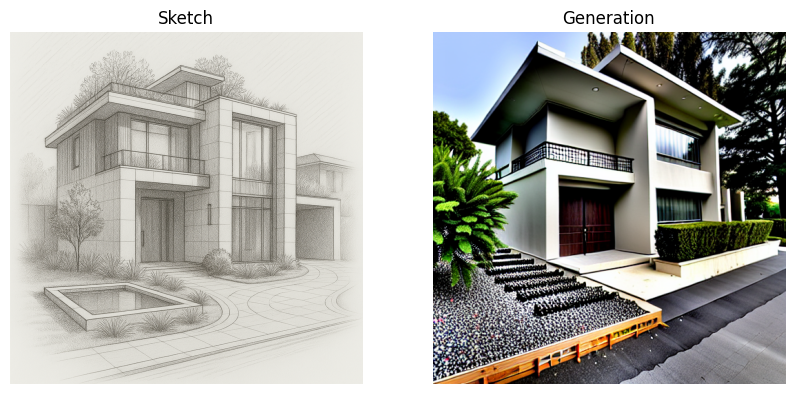

In [6]:



prompt="Rectangular house with flat roof made of concrete"
controlnet.eval()
with torch.no_grad():
    generated_image = run_controlnet_inference(
        prompt=prompt,
        control_image=val_img,
        noise_scheduler=noise_scheduler,
        tokenizer=tokenizer,
        text_encoder=text_encoder,
        vae=vae,
        unet=unet,
        num_inference_steps = 30,
        controlnet=controlnet,
        device=device,
        weight_dtype=weight_dtype,
        inject_lora=False
    )

print(f'Guidance_prompt: {prompt}')
show_images_side_by_side(
    [val_img, generated_image],
    titles=["Sketch", "Generation"]
)


# Run Inference on all images of train set <WIP>

In [ ]:


# Path to sketches and prompts
sketch_folder = "/kaggle/input/sketch-2-image-dataset/construction_sketch_dataset/construction_sketch_dataset/Sketches"
prompts_path = "/kaggle/input/sketch-2-image-dataset/prompts.json"  

# Load prompts from JSON
with open(prompts_path, "r") as f:
    prompts_list = json.load(f)

prompts_dict = {item["image"]: item["prompt"] for item in prompts_list}

# Ensure model is in eval mode
controlnet.eval()
unet.eval()
vae.eval()
text_encoder.eval()

# Get list of image paths
image_files = [os.path.join(sketch_folder, f) for f in os.listdir(sketch_folder)
               if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# Iterate over all sketches
with torch.no_grad():
    for image_path in tqdm(image_files, desc="Generating from sketches"):
        # Extract filename
        filename = os.path.basename(image_path)

        # Get corresponding prompt (fallback to empty if not found)
        prompt = prompts_dict.get(filename.replace("sketch_", "image_"), "")

        # Load sketch image
        pil_image = Image.open(image_path).convert("RGB")

        # Run inference
        generated_image = run_controlnet_inference(
            prompt=prompt,
            control_image=pil_image,
            noise_scheduler=noise_scheduler,
            tokenizer=tokenizer,
            num_inference_steps=50,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            controlnet=controlnet,
            device=device,
            weight_dtype=weight_dtype,
            inject_lora=False
        )


        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(pil_image)
        ax[0].set_title("Original Sketch")
        ax[0].axis("off")
        ax[1].imshow(generated_image)
        ax[1].set_title("Generated Image")
        ax[1].axis("off")
        plt.suptitle(f"{filename} | Prompt: {prompt}")
        plt.tight_layout()
        plt.show()
